<a href="https://colab.research.google.com/github/AmedeeRoy/BirdGAN/blob/master/code/2_gan_vs_hmm_200_steps_SS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
%cd drive/My\ Drive/

[Errno 2] No such file or directory: 'drive/My Drive/'
/content/drive/My Drive


## load data

In [4]:
from utils.tools import *

In [28]:
# import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import progressbar
import time

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torchvision as tv

In [35]:
data = pd.read_table('./data/trips_SS_200_steps.csv', sep = ',')
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

# colony = (-77.264, -11.773)
colony =  (-32.392, -3.819)
scale = 2e5
data = format_data(data, colony, scale)
data = data[data.dist_colony > 1000]

padding = 200
traj = padding_data(data, padding)

print('range : \nmin : ' + str(np.min(traj)) + '\nmax : ' + str(np.max(traj)))

range : 
min : -0.3200725766295411
max : 0.8840802716939067


In [12]:
class TrajDataSet(Dataset):
    def __init__(self,  traj, transform=None):
        self.traj = traj
        self.transform = transform

    def __len__(self):
        return self.traj.shape[0]

    def __getitem__(self, idx):
        # select coordinates
        sample = self.traj[idx,:,:]
        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        return torch.FloatTensor(sample)

In [16]:
# hyperparameters
batch_size = 15
resolution = 60

## reduce size dataset
train_set = TrajDataSet(traj, transform= ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)

In [17]:
x =  next(iter(train_loader))

In [18]:
len(train_set)

31

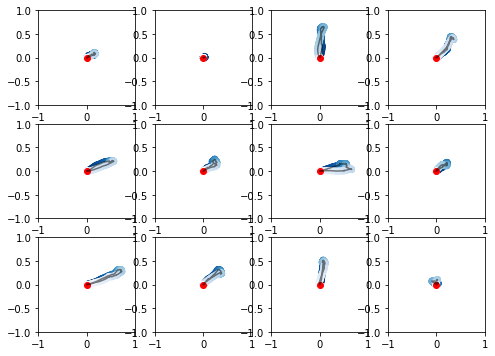

In [19]:
plt.figure(figsize = (8,8))
i = 4

for i in range(12):
    plt.subplot(4,4,i+1)
    plt.plot(x.numpy()[i,0,:], x.numpy()[i,1,:], c = 'black', alpha = 0.5)
    plt.scatter(x.numpy()[i,0,:], x.numpy()[i,1,:], c=np.arange(padding), cmap='Blues_r')
    plt.scatter(0,0, c = 'red')
    plt.xlim(-1,1)
    plt.ylim(-1,1)


## deep networks

Architecture guidelines for stable Deep Convolutional GANs (Radford et al. 2016)

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.



In [20]:
import torch
from torch import nn
from torch import optim
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
class CNNGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(    
            nn.ConvTranspose1d(256, 128, kernel_size = 25, stride = 2, padding = 0, bias = False),
            nn.BatchNorm1d(128),
            nn.ReLU(True),

            nn.ConvTranspose1d(128, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.ReLU(True),

            nn.ConvTranspose1d(32, 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(8),
            nn.ReLU(True),

            nn.ConvTranspose1d(8, 2, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.Tanh()
         )

    def forward(self, z):    
        out = self.cnn(z)

        return out

In [23]:
z = torch.rand((batch_size, 256, 1), device = device)
gen = CNNGenerator().to(device)
gen(z).shape

torch.Size([15, 2, 200])

In [24]:
class CNNDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
                
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(8, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(32, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(128, 1, kernel_size=25, stride=2, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):


        out = self.cnn(x)

        return out.squeeze(1)


In [25]:
dis = CNNDiscriminator().to(device)
dis(x.to(device)).shape

torch.Size([15, 1])

# training

In [26]:
def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = CNNGenerator().to(device)
discriminator = CNNDiscriminator().to(device)

### WEIGHT INITIALIZATION
generator.apply(weights_init)
discriminator.apply(weights_init)

criterion = nn.BCELoss()

lr = 0.0002
optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optim_g = optim.Adam(generator.parameters(),lr= lr, betas=(0.5, 0.999))

target_ones = torch.ones((batch_size, 1), device=device)
target_zeros = torch.zeros((batch_size, 1), device=device)

In [29]:
def periodogram(tt):
  periodogram = torch.mean(torch.fft.fft(tt, 200).abs(), 0)
  return torch.log(periodogram)

  9% (499 of 5000) |##                   | Elapsed Time: 0:00:08 ETA:   0:01:19


Epoch [501/5000] -----------------------------------------------------------------------------
G: 1.7, Dr : 0.0, Df : 0.0


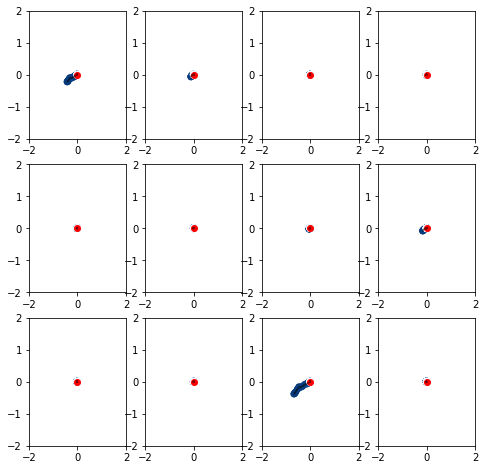

 19% (999 of 5000) |####                 | Elapsed Time: 0:00:18 ETA:   0:01:08


Epoch [1001/5000] -----------------------------------------------------------------------------
G: 1.85, Dr : 0.0, Df : 0.0


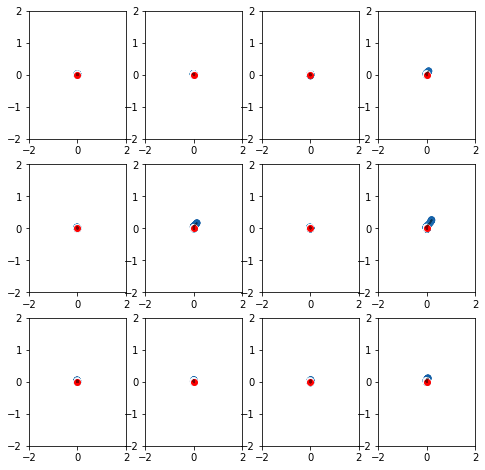

 29% (1496 of 5000) |#####               | Elapsed Time: 0:00:28 ETA:   0:01:00


Epoch [1501/5000] -----------------------------------------------------------------------------
G: 1.86, Dr : 0.0, Df : 0.0


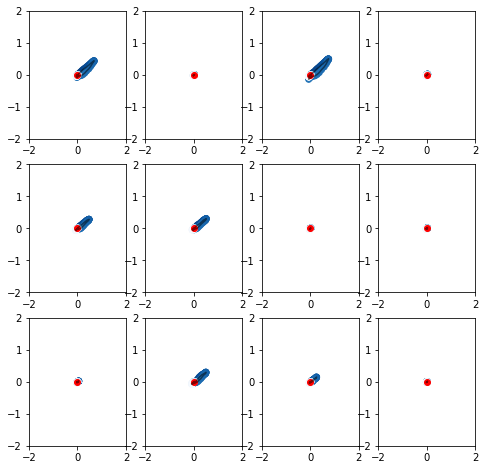

 39% (1999 of 5000) |#######             | Elapsed Time: 0:00:38 ETA:   0:00:53


Epoch [2001/5000] -----------------------------------------------------------------------------
G: 1.41, Dr : 0.0, Df : 0.0


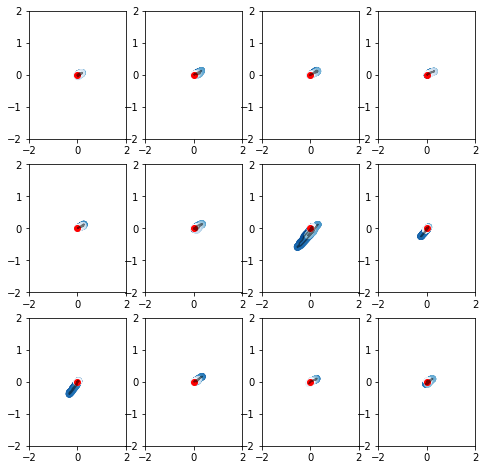

 49% (2499 of 5000) |#########           | Elapsed Time: 0:00:48 ETA:   0:00:43


Epoch [2501/5000] -----------------------------------------------------------------------------
G: 0.65, Dr : 0.01, Df : 0.01


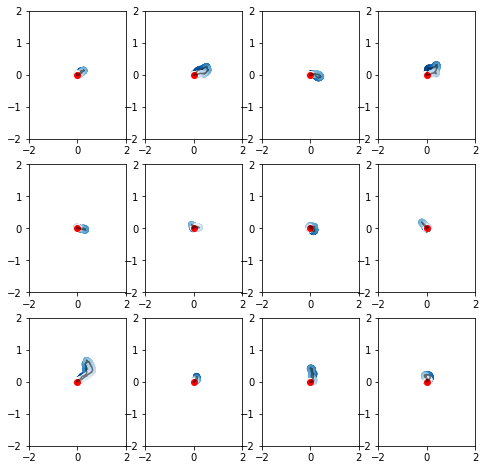

 59% (2999 of 5000) |###########         | Elapsed Time: 0:00:58 ETA:   0:00:35


Epoch [3001/5000] -----------------------------------------------------------------------------
G: 0.41, Dr : 0.01, Df : 0.03


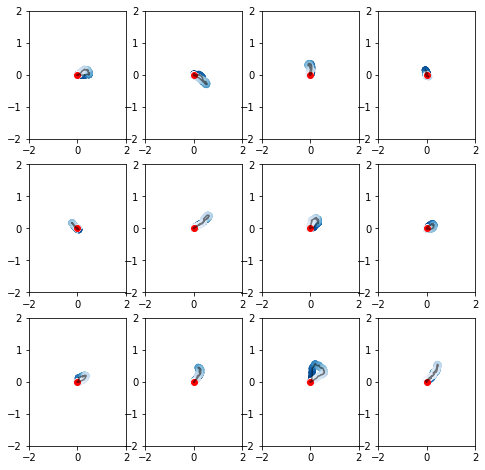

 69% (3495 of 5000) |#############       | Elapsed Time: 0:01:07 ETA:   0:00:26


Epoch [3501/5000] -----------------------------------------------------------------------------
G: 0.49, Dr : 0.01, Df : 0.04


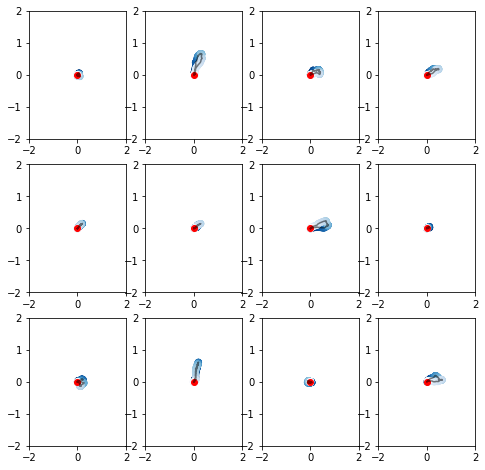

 79% (3994 of 5000) |###############     | Elapsed Time: 0:01:17 ETA:   0:00:17


Epoch [4001/5000] -----------------------------------------------------------------------------
G: 0.49, Dr : 0.0, Df : 0.01


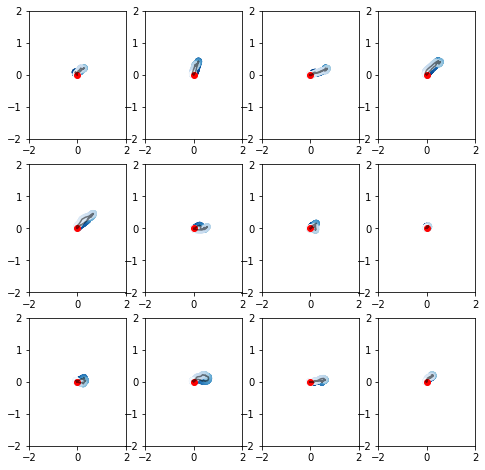

 89% (4493 of 5000) |#################   | Elapsed Time: 0:01:27 ETA:   0:00:08


Epoch [4501/5000] -----------------------------------------------------------------------------
G: 0.41, Dr : 0.0, Df : 0.01


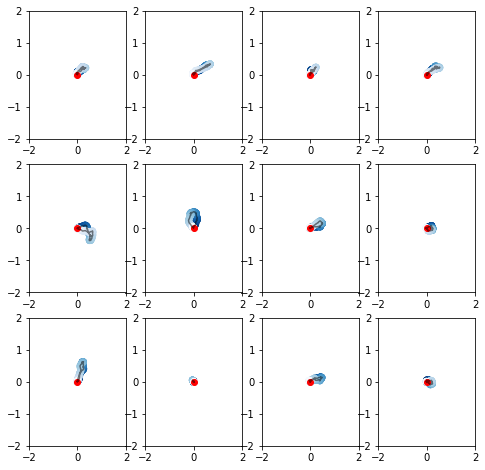

 99% (4998 of 5000) |################### | Elapsed Time: 0:01:37 ETA:   0:00:00


Epoch [5001/5000] -----------------------------------------------------------------------------
G: 0.62, Dr : 0.02, Df : 0.0


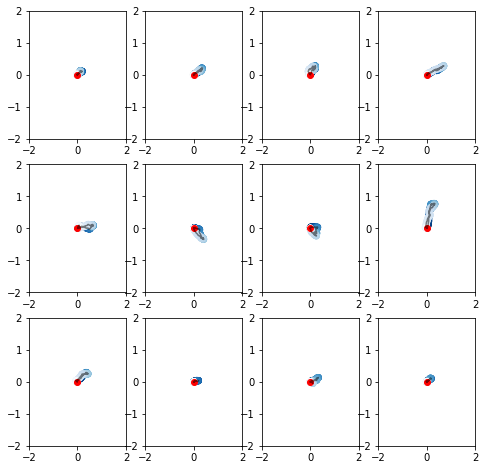

100% (5000 of 5000) |####################| Elapsed Time: 0:01:38 Time:  0:01:38


In [31]:
# Train the model
nb_epoch = 5000

time_start = time.perf_counter()
epoch = 0
for i in progressbar.progressbar(range(nb_epoch)):
    epoch +=1
    loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
    for batch, x in enumerate(train_loader):
        
        #### TRAIN DISCRIMINATOR
        ## true samples
        x = x.to(device)
        batch_size = x.shape[0]

        target_ones = torch.ones((batch_size, 1), device=device)
        target_zeros = torch.zeros((batch_size, 1), device=device)

        discriminator.zero_grad()
        pred_real = discriminator(x)
        loss_real = criterion(pred_real, target_ones)

        ## false samples
        z = torch.randn((batch_size, 256, 1), device=device)
        with torch.no_grad():
            fake_samples = generator(z)
        pred_fake = discriminator(fake_samples)
        loss_fake = criterion(pred_fake, target_zeros)
        
        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        optim_d.step()

        loss_d_real_running += loss_real.item()
        loss_d_fake_running += loss_fake.item()

        #### TRAIN GENERATOR
        generator.zero_grad()
        z = torch.randn((batch_size, 256, 1), device=device)

        generated = generator(z)
        classifications = discriminator(generated)
        loss = criterion(classifications, target_ones) +  10*torch.mean((periodogram(generated) - periodogram(x))**2)
        loss.backward()
        optim_g.step()

        loss_g_running += loss.item()   

    if epoch%500 == 0:
        print('\nEpoch [{}/{}] -----------------------------------------------------------------------------'
            .format(epoch+1, nb_epoch, i, len(train_loader)))
        print('G: {}, Dr : {}, Df : {}'
            .format(np.round(loss_g_running/batch_size, 2), np.round(loss_d_real_running/batch_size, 2), np.round(loss_d_fake_running/batch_size, 2)))
        
        nb = 16
        z = torch.randn((nb, 256, 1), device=device)
        with torch.no_grad():
          generated = generator(z)
        
        traj_sim = generated.cpu().detach().numpy()

        plt.figure(figsize = (8,8))

        for i in range(16):
          plt.subplot(4,4,i+1)
          plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
          plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(padding), cmap='Blues_r')
          plt.scatter(0,0, c = 'red')
          plt.xlim(-2,2)
          plt.ylim(-2,2)

        plt.show()
        plt.close()

In [32]:
nb = 100
z = torch.randn((100, 256, 1), device=device)
with torch.no_grad():
  generated = generator(z)

traj_sim = generated.cpu().detach().numpy()

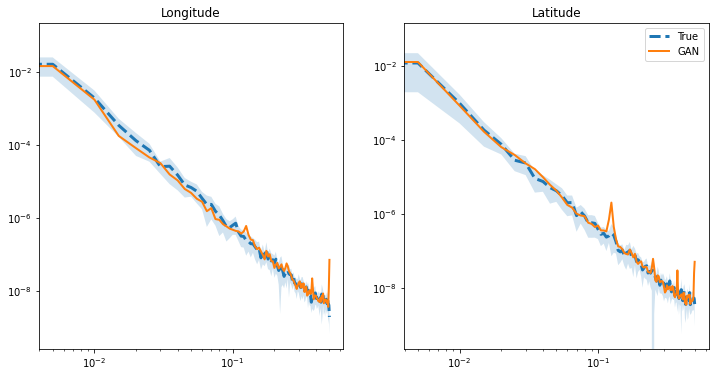

0.21276472605547883

In [33]:
get_score(traj, traj_sim, plot=True)

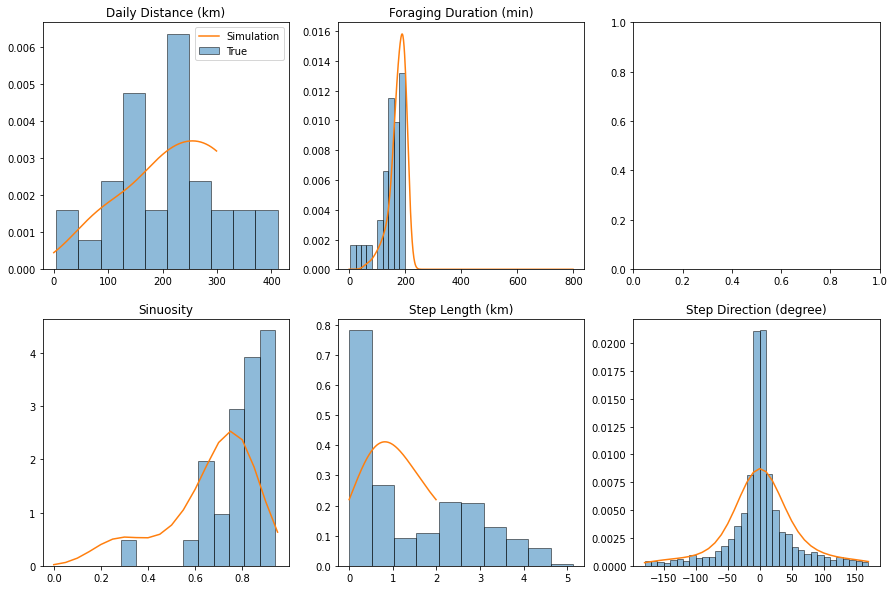

In [36]:
data_fake = format_simulation(traj_sim, colony, scale)
data_fake = data_fake[data_fake.dist_colony > 1000]

get_distribution(data, data_fake)
plt.show()
plt.close()

In [37]:
torch.save(generator, 'SS_200_steps_G.pt')
torch.save(discriminator, 'SS_200_steps_D.pt')